In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os

pd.set_option('display.max_columns', None)

imputedDataset = pd.read_stata("/Users/burke/Documents/research/bpCog/mcm/mcm/data/fullyImputedDataset.dta")
imputedDataset.head()

,index,WTINT2YR,a1c,age,bmi,diedBy2011,gender,hdl,ldl,timeInUS,tot_chol,trig,weight,year,meanSBP,meanDBP,raceEthnicity,smokingStatus
0,0,102641.406474,5.1,22.0,23.3,0,1.0,41.0,110.0,NaN,168.0,0.948,69.2,2011,110.666667,74.666667,3,0
1,1,127351.373299,4.9,44.0,23.2,0,2.0,28.0,151.0,NaN,190.0,0.632,67.2,2011,118.000000,60.000000,3,0
2,2,14391.778470,5.4,21.0,20.1,0,1.0,43.0,73.0,NaN,132.0,0.881,54.6,2011,124.666667,78.000000,5,0
3,3,26960.774346,5.6,43.0,33.3,0,2.0,73.0,68.0,NaN,169.0,1.592,98.6,2011,102.000000,71.333333,4,2
4,4,24912.668432,5.0,80.0,33.9,0,1.0,54.0,132.0,NaN,203.0,1.084,95.8,2011,98.000000,38.000000,3,0


# Now the goal is to see what the risk factors would look like for the NHANES 1999 population, if we advanced them to 20110

For the NHANES side of things, we want the blood pressure distribution in 2011 that excludes people that moved into the coutnry in the prior 12 years (since 1999). 

For the simulation side of things, we'll need to load the mortality data so that we can take out the poeple that died between 1999 and 2011.



count    4297.000000
mean      123.849585
std        17.825786
min        80.666667
25%       112.000000
50%       122.000000
75%       132.000000
max       234.666667
Name: meanSBP, dtype: float64


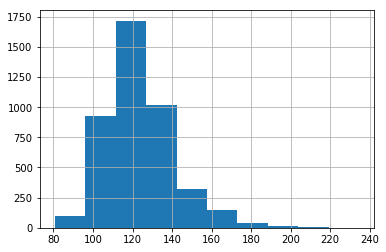

In [2]:
% matplotlib inline
noRecentUSInmigration = imputedDataset.loc[~imputedDataset.timeInUS.isin([1,2,3])]
recentCrossSectionOfNonImmigrants = noRecentUSInmigration.loc[noRecentUSInmigration.year==2011]
# the simulated cohort starts in 1999 and then ages people forward 11 years...so, teh youngest age is 29
recentCrossSectionOfNonImmigrants = recentCrossSectionOfNonImmigrants.loc[recentCrossSectionOfNonImmigrants.age > 18 +11]
recentCrossSectionOfNonImmigrants = recentCrossSectionOfNonImmigrants.sample(n=len(recentCrossSectionOfNonImmigrants), weights=recentCrossSectionOfNonImmigrants.WTINT2YR, replace=True)


print (recentCrossSectionOfNonImmigrants.meanSBP.describe())
recentCrossSectionOfNonImmigrants.meanSBP.hist()

count    5306.000000
mean      123.856138
std        19.543664
min        82.666667
25%       110.666667
50%       120.666667
75%       132.666667
max       231.333333
Name: meanSBP, dtype: float64


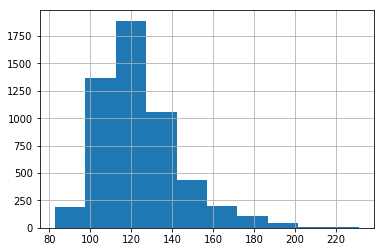

In [3]:
earlyCrossSectionOfNonImmigrants = imputedDataset.loc[imputedDataset.year==2001]
# here we just need to throw out the very young people for comparisons
earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.loc[earlyCrossSectionOfNonImmigrants.age > 18 + 2]
earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.sample(n=len(earlyCrossSectionOfNonImmigrants), weights=earlyCrossSectionOfNonImmigrants.WTINT2YR, replace=True)

print (earlyCrossSectionOfNonImmigrants.meanSBP.describe())

earlyCrossSectionOfNonImmigrants.meanSBP.hist()

Reasons that our risk factors might not match up with what we hoped:
- Non-normality of the underlying blood pressures and failure to to accoutn for high outliers, in particular
- Failure to update other risk factors over time, dragging down the other population means - i dont' think that's likely to be it...after fixing the DBP model, it didn't fix much...
- We didn't kill poeple off yet — not it...using the survivors, we don't see anythnig...

count    4297.000000
mean      120.723081
std        16.078688
min        80.682338
25%       109.562216
50%       119.046316
75%       129.516594
max       232.058922
dtype: float64


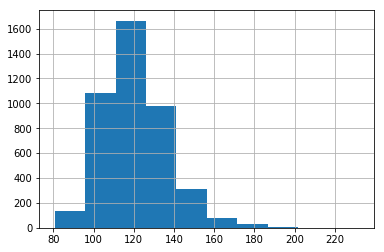

In [4]:
% matplotlib inline
import os
os.chdir("/Users/burke/Documents/research/bpCog/mcm")
from mcm.population import NHANESDirectSamplePopulation

pop = NHANESDirectSamplePopulation(n=5000, year=1999)
pop.advance(10)

sbps = pd.Series([ person._sbp[-1] for person in pop._people if not person.diedBy2011])

sbps.hist()
print(sbps.describe())

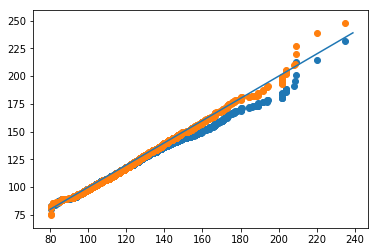

In [16]:
% matplotlib inline
import matplotlib.pyplot as plt

firstSBPS = pd.Series([ person._sbp[1] for person in pop._people])


plt.scatter(recentCrossSectionOfNonImmigrants.meanSBP.sort_values(), 
     sbps.sample(n=len(recentCrossSectionOfNonImmigrants)).sort_values())
plt.scatter(recentCrossSectionOfNonImmigrants.meanSBP.sort_values(), 
     firstSBPS.sample(n=len(recentCrossSectionOfNonImmigrants)).sort_values())


plt.plot(np.arange(80,240), np.arange(80, 240))

In [ ]:
from mcm.log_linear_risk_factor_model import LogLinearRiskFactorModel
from statsmodels.regression.linear_model import OLSResults

modelResults = OLSResults.load("mcm/data/logSBPModel.pickle")

sbpModel = LogLinearRiskFactorModel("sbp", modelResults.params, modelResults.bse, modelResults.resid)

estiamtes = [sbpModel.estimate_next_risk(age = pd.Series([person._age[0] for person in pop._people]).mean(),
                            gender=pd.Series([person._gender for person in pop._people]).mean(),
                            race_ethnicity=pd.Series([person._race_ethnicity for person in pop._people]).mean(),
                            sbp=pd.Series([person._sbp[0] for person in pop._people]).mean(),
                            dbp=pd.Series([person._dbp[0] for person in pop._people]).mean(),
                            a1c=pd.Series([person._a1c[0] for person in pop._people]).mean(),
                            hdl=pd.Series([person._hdl[0] for person in pop._people]).mean(),
                            chol=pd.Series([person._tot_chol[0] for person in pop._people]).mean(),
                            bmi=pd.Series([person._bmi[0] for person in pop._people]).mean(),
                            smoking_status=pd.Series([person._smoking_status for person in pop._people]).mean())
             for count in range(5000)]
pd.Series(estiamtes).describe()
                            

In [ ]:
pd.Series([person._dbp[0] for person in pop._people]).describe()

One thing that needs to be figured out...is the problem that smoking status and BMI (particularly BMI) arne't figuring into the regression models...we're essentially aasuming that everybody has a 0 BMI...and BMI has a nin-trivial effect on BP...that could push the means down, right?